# Notebook to demonstrate the climate tools available
Based on data retreived via the cdsapi, you will need a cdsapi key to download the data

In [2]:
# Imports
import os
import xarray as xr
import cdsapi

from earthkit import climate

In [3]:
# Create directories 
if not os.path.isdir('test_data'): os.mkdir('test_data')

# set constants
YEARS = [2015]

In [4]:
# Download 5 years of hourly ERA5 data for europe
c = cdsapi.Client()
out_fnames = []
for year in YEARS:
    out_fnames += [f"test_data/era5_temperature_europe_{year}.grib"]
    if not os.path.isfile(out_fnames[-1]):
        c.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis',
                'variable': '2m_temperature',
                'year': year,
                'month': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                ],
                'day': [
                    '01', '02', '03',
                    '04', '05', '06',
                    '07', '08', '09',
                    '10', '11', '12',
                    '13', '14', '15',
                    '16', '17', '18',
                    '19', '20', '21',
                    '22', '23', '24',
                    '25', '26', '27',
                    '28', '29', '30',
                    '31',
                ],
                'time': [
                    '00:00', '06:00', '12:00', '18:00',
                ],
                'area': [
                    80, -10, 30, 60,
                ],
                'format': 'grib',
            },
        ).download(target=out_fnames[-1])



In [5]:
# Open data in xarray
t2m_data_in = xr.open_mfdataset(out_fnames, chunks={'time':48})
t2m_data = t2m_data_in.isel(latitude=100,longitude=100)
t2m_data

<xarray.Dataset>
Dimensions:     (time: 1460)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2015-01-01 ... 2015-12-31T18:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    float64 55.0
    longitude   float64 15.0
    valid_time  (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Data variables:
    t2m         (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-05-25T12:50 GRIB to CDM+CF via cfgrib-0.9.1...

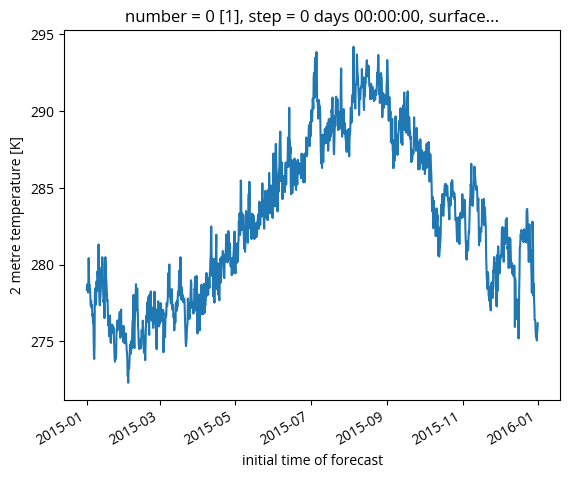

In [6]:
t2m_data.t2m.plot()

In [7]:
t2m_rolling = climate.aggregate.rolling_reduce(
    t2m_data, time=50, center=True, how_dropna='all'
)
t2m_rolling

rolling kwargs:  {'time': 50, 'center': True}
reduce kwargs:  {}


<xarray.Dataset>
Dimensions:     (time: 1411)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-07T06:00:00 ... 2015-12-25T18:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    float64 55.0
    longitude   float64 15.0
    valid_time  (time) datetime64[ns] dask.array<chunksize=(23,), meta=np.ndarray>
Data variables:
    t2m         (time) float32 dask.array<chunksize=(48,), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-05-25T12:50 GRIB to CDM+CF via cfgrib-0.9.1...

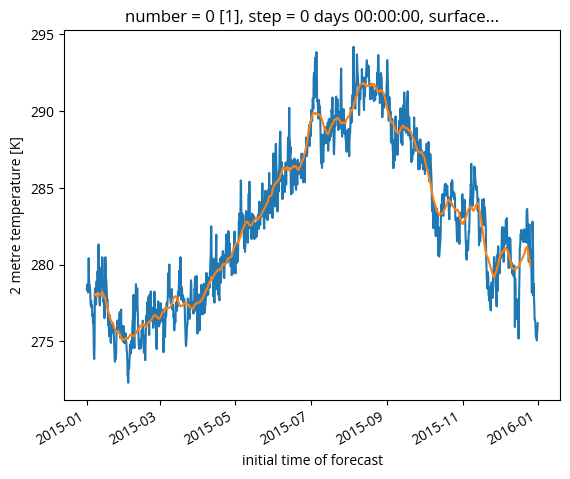

In [8]:
t2m_data.t2m.plot()
t2m_rolling.t2m.plot()

In [9]:
climate.aggregate.rolling_reduce(
    t2m_data_in, time=30, lat=5, lon=5, center=True,
    how_dropna='all'
)

rolling kwargs:  {'time': 30, 'center': True}
reduce kwargs:  {'lat': 5, 'lon': 5}


<xarray.Dataset>
Dimensions:     (time: 1431, latitude: 201, longitude: 281)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-04T18:00:00 ... 2015-12-28T06:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time) datetime64[ns] dask.array<chunksize=(33,), meta=np.ndarray>
Data variables:
    t2m         (time, latitude, longitude) float32 dask.array<chunksize=(48, 201, 281), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-05-25T12:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
rolling_kwargs =  {'time': 50, 'center': True}
reduce_kwargs =  {}
data_rolling = t2m_data_in.rolling(**rolling_kwargs)
data_rolling

DatasetRolling [time->50(center)]

In [11]:
climate.aggregate.reduce(data_rolling).dropna('time', how='all')

<xarray.Dataset>
Dimensions:     (time: 1411, latitude: 201, longitude: 281)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2015-01-07T06:00:00 ... 2015-12-25T18:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 -10.0 -9.75 -9.5 -9.25 ... 59.5 59.75 60.0
    valid_time  (time) datetime64[ns] dask.array<chunksize=(23,), meta=np.ndarray>
Data variables:
    t2m         (time, latitude, longitude) float32 dask.array<chunksize=(48, 201, 281), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-05-25T12:50 GRIB to CDM+CF via cfgrib-0.9.1...